# Introduction

In this notebook, we analyse a sample of PBMCs. Here, we explore a transition from classical to non-classical monocytes.

## Load packages

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [2]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_

Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots, but switch to smaller legends here to avoid overlap of the plot and the legend. You can set the context as well to 'poster' or 'paper'.

In [3]:
sb.set_context(context='talk')


# Set project file paths

We set up the file paths to the respective directories.

In [4]:
file_path = '/root/host_home/Documents/ICB/Teaching/2103_scanpy_HMGU_presenter/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [6]:
file_path_raw = file_path + '3k_PBMC/'

The data directory contains all processed data and `anndata` files. 

In [7]:
data_dir = file_path + 'PBMC_docker/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [8]:
table_dir = file_path + 'PBMC_docker/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [9]:
sc.settings.figdir = file_path + 'PBMC_docker/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [10]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

The annotated dataset, which consists of 3k PBMCs (Human) provided by 10X Genomics.

In [31]:
adata = sc.read(data_dir + 'data_annotated.h5ad')

# Pseudotime analysis on Monocytes

In this section, we want to explore a potential transition of CD14+ and FCGR3A+ Monocytes.

Select the monocytes.

In [32]:
adata_mono = adata[np.in1d(adata.obs['annotated'], 
                           ['CD14+ monocytes', 'FCGR3A+ monocytes'])].copy()

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [33]:
adata_mono

AnnData object with n_obs × n_vars = 932 × 12238
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'batch', 'size_factors', 'S_score', 'G2M_score', 'phase', 'umap_density', 'louvain_r1.5', 'louvain_r0.5', 'leiden_r1.5', 'leiden_r0.5', 'annotated', 'leiden_R'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotated_colors', "dendrogram_['leiden_r0.5']", 'diffmap_evals', 'draw_graph', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_r0.5_colors', 'leiden_r1.5_colors', 'louvain', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'rank_genes_r0.5', 'rank_genes_r1.5', 'umap', 'umap_density

Compute a diffusion pseudotime (DPT). 

Note: Fix a root cell as `adata.uns['iroot']` first. 

Visualize the pseudotime on the embedding. 

Compute the differentially expressed genes between the two subgroups and visualize the expression of 20 top differentially expressed genes along pseudotime.

In [34]:
sc.tl.pca(adata_mono, svd_solver='arpack')
sc.pp.neighbors(adata_mono)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


Convert UMAP indices to arrays.

In [35]:
umap_0 = [term[0] for term in adata_mono.obsm['X_umap']]
umap_1 = [term[1] for term in adata_mono.obsm['X_umap']]

Set root cell to the cell with the smallest value in the first UMAP component and compute DPT.

In [36]:
adata_mono.uns['iroot'] = np.flatnonzero(umap_0== max(umap_0))[0]
sc.tl.dpt(adata = adata_mono)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Visualise DPT on a UMAP and on a diffusion map.

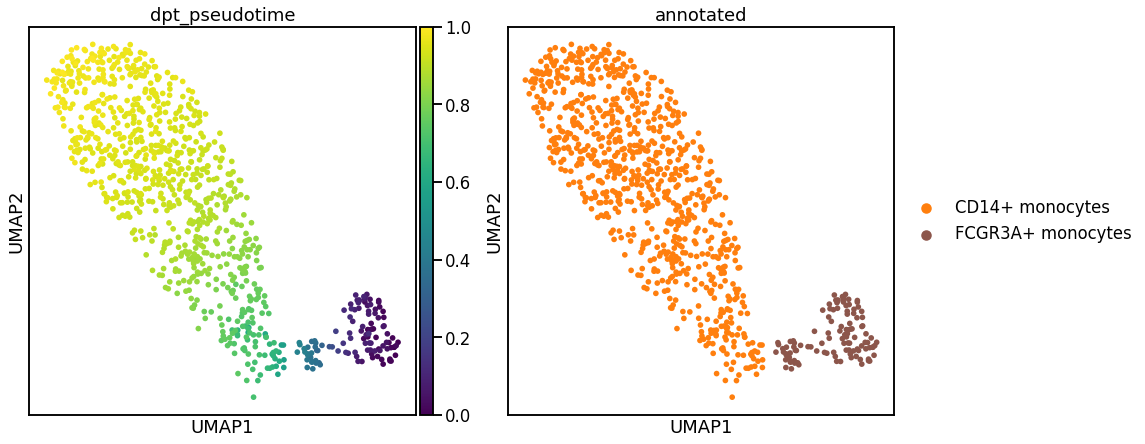

In [37]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_mono, color=['dpt_pseudotime', 'annotated'])

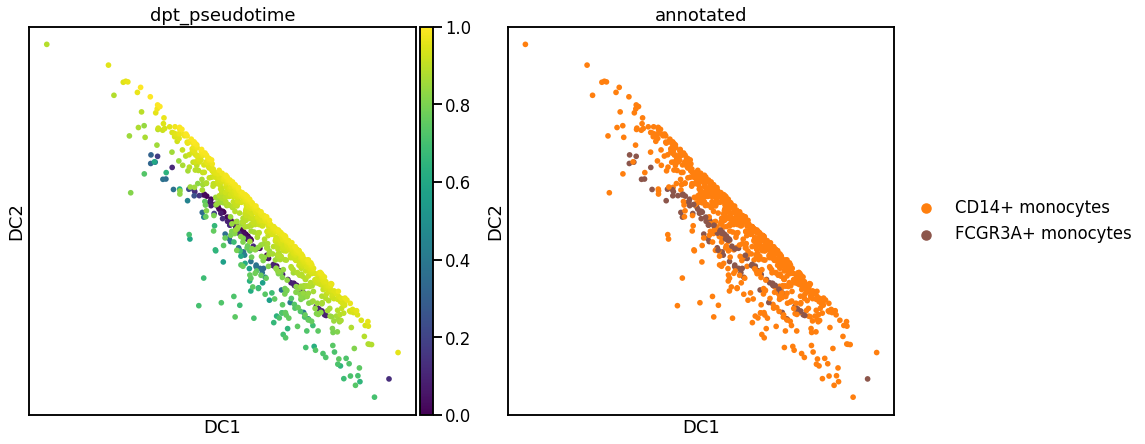

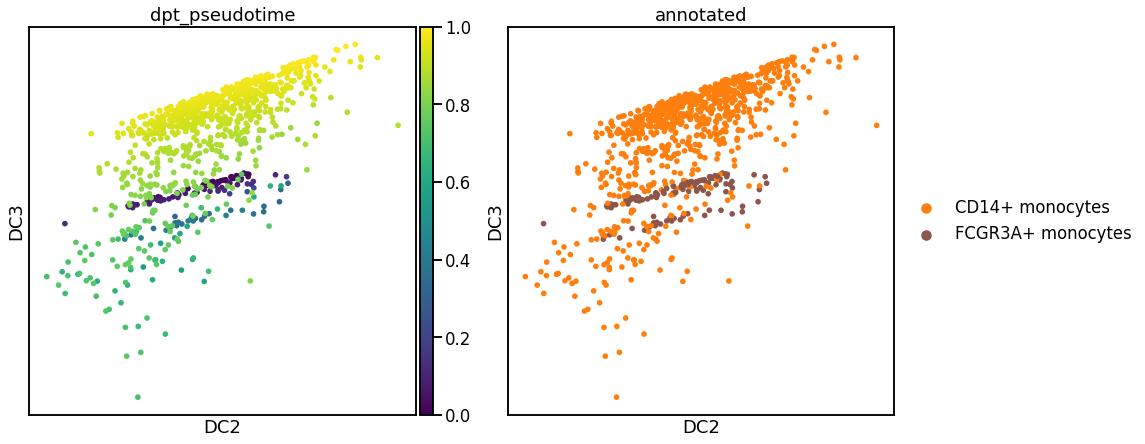

In [38]:
rcParams['figure.figsize']=(7,7)
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['1,2'])
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['2,3'])

Run a differential test on the two groups of monocytes in order to determine characteristic genes.  

In [39]:
sc.tl.rank_genes_groups(adata_mono, groupby='annotated', 
                        groups= ['FCGR3A+ monocytes'], reference='CD14+ monocytes', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


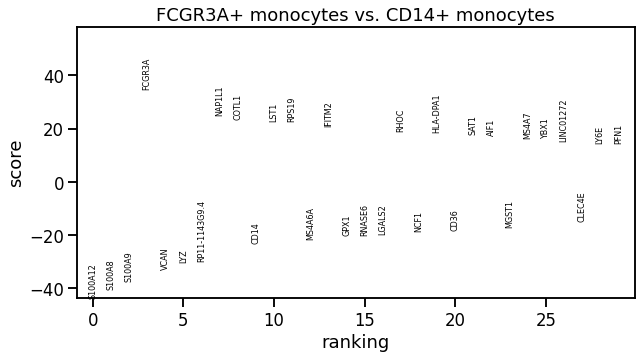

In [40]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata_mono, size=10, n_genes=30)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


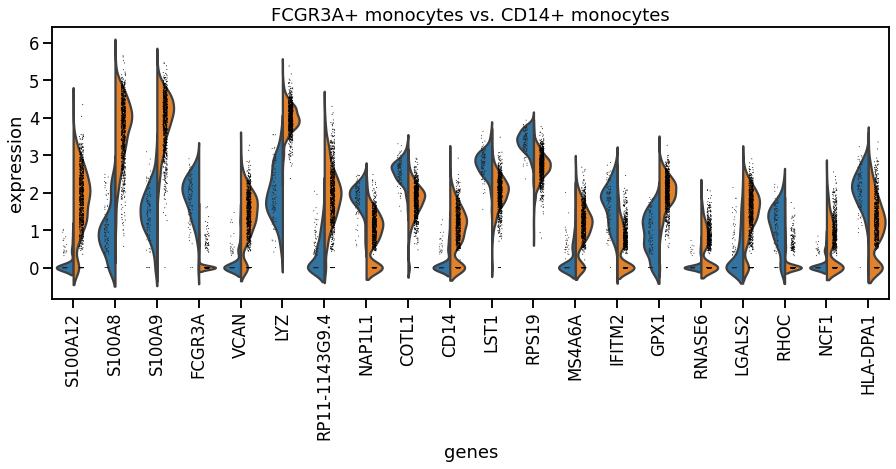

In [41]:
rcParams['figure.figsize']= (15,5)
sc.pl.rank_genes_groups_violin(adata_mono, use_raw=False)

In [42]:
mono_genes = [idx[1][0] for idx in enumerate(adata_mono.uns['rank_genes_groups']['names'])]


In order to visualise the gene expression along pseudotime, we have to compute PAGA for the two groups of monocytes.

In [43]:
sc.tl.paga(adata_mono, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


Modify the format of the data matrix, because `paga_path` takes only dense matrices (in this `scanpy` version).

In [45]:
adata_mono.X = adata_mono.X.todense()

/opt/python/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1177: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/opt/python/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1220: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


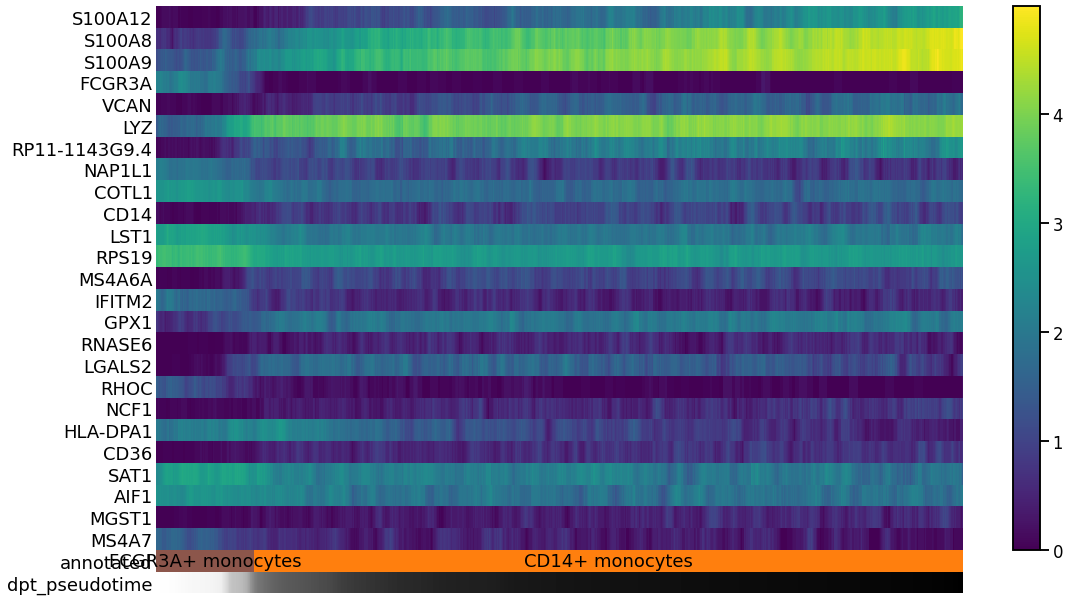

In [46]:
rcParams['figure.figsize']=(20,10)
sc.pl.paga_path(adata_mono, nodes=['FCGR3A+ monocytes','CD14+ monocytes'], 
                keys=mono_genes[:25],
                n_avg=10, #smooth over 10 adjacent cells
                use_raw=False, 
                save= '_' + today + '_monocyte_transition.pdf')

**Comment:** End of seventh session.